In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchsummary import summary

import os
import pyworld
import librosa
import time
import matplotlib.pyplot as plt

from preprocess import *
from model import *

torch.manual_seed(0)
np.random.seed(0)

In [2]:
model_dir = "./model/model_mc32_fr1024"
model_name = "model_mc32_fr1024"

data_dir = "./data/voice_data"
# voice_dir = ["F4", "F5", "F6", "M2"]
voice_dir = ["test01", "test02"]

output_dir = "./converted_voices/test"
figure_dir = "./figure/model_mc32_fr1024"

In [3]:
if (False):
    for v in voice_dir:
        print("Preprocess: " + v)
        preprocess_voice(os.path.join(data_dir, v), v)

In [4]:
num_epochs = 2 #10000
batch_size = 1
learning_rate =1e-3 

sampling_rate = 16000
num_mcep = 36
frame_period = 5.0
n_frames = 1024 

losses = []
loss_num = 0

In [5]:
def model_save(model, model_dir, model_name):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    torch.save(model.state_dict(), os.path.join(model_dir, model_name))
    
def model_load(model_dir, model_name):
    model = ACVAE()
    model.load_state_dict(torch.load(os.path.join(model_dir, model_name)))

In [6]:
def data_load(batchsize = 1, s = -1, t = -1):
    x = []
    label = []
    for i in range(batchsize):
        if (s == -1):
            label_num = np.random.randint(len(voice_dir))
        else:
            label_num = s
        voice_path = os.path.join(data_dir, voice_dir[label_num])
        files = os.listdir(voice_path)
        
        frames = 0
        while frames < n_frames:
            
            file = ""
            while file.count("wav") == 0:
                file = np.random.choice(files)
            print(file)
            wav, _ = librosa.load(os.path.join(voice_path, file), sr = sampling_rate, mono = True)
            wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
            f0, timeaxis, sp, ap = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period)
            coded_sp = world_encode_spectral_envelop(sp = sp, fs = sampling_rate, dim = num_mcep)
            coded_sp_transposed = coded_sp.T
            frames = np.shape(coded_sp_transposed)[1]
            
        mcep_normalization_params = np.load(os.path.join(voice_path, "mcep_"+voice_dir[label_num]+".npz"))
        mcep_mean = mcep_normalization_params['mean']
        mcep_std = mcep_normalization_params['std']
        coded_sp_norm = (coded_sp_transposed - mcep_mean) / mcep_std
            
        start_ = np.random.randint(frames - n_frames + 1)
        end_ = start_ + n_frames
            
        x.append(coded_sp_norm[:,start_:end_])
        label.append(label_num)

    return torch.Tensor(x).view(batchsize, 1, num_mcep, n_frames), torch.Tensor(label)

In [7]:
def predict(model):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

cpu
Epoch: 1
tsuchiya_normal_001.wav


/Users/aoi/Workspace/Python/ACVAE-VC/model.py:142: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  h13_ = F.softmax(self.ac_conv5(h12))


Time Elapsed for one epoch: 00:00:02
Epoch: 2
hiroshiba_normal_001.wav.wav
Time Elapsed for one epoch: 00:00:02


FileNotFoundError: [Errno 2] No such file or directory: './figure/model_mc32_fr1024/epoch_00002.png'

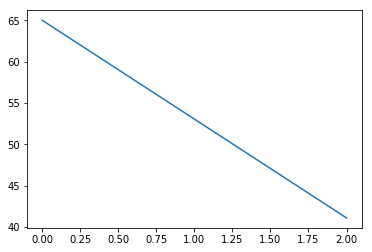

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ACVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()

for epoch in range(num_epochs):
    epoch += 1
    
    start_time = time.time()

    print('Epoch: %d' % epoch)

    x_, label_ = data_load(batch_size)
    optimizer.zero_grad()
    loss = model.calc_loss(x_, label_)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    loss_num += 1
    
    if epoch % 100 == 0:
        predict(model)
    if epoch % 100 == 0:
        model_save(model, model_dir, model_name)
    if epoch % 2000 == 0:
        model_save(model, model_dir, model_name + "_" + str(epoch))

    if epoch % 10 == 0:
        if not os.path.exists(figure_dir):
            os.makedirs(figure_dir)
        x = np.linspace(0, loss_num, loss_num)
        plt.figure()
        plt.plot(x, losses)
        plt.savefig(figure_dir + "/" + "epoch_{:05}".format(epoch) + ".png")

    elapsed_time = time.time() - start_time
    print('Time Elapsed for one epoch: %02d:%02d:%02d' % (elapsed_time // 3600, (elapsed_time % 3600 // 60), (elapsed_time % 60 // 1)))        

model_save(model, model_dir, model_name)

x = np.linspace(0, loss_num, loss_num)
plt.figure()
plt.plot(x, losses)
plt.savefig(figure_dir + "/" + "epoch_{:05}".format(num_epochs) + ".png")

In [ ]:
a, b= data_load(2)

In [ ]:
np.shape(a)

In [ ]:
plt.hist(np.array(a[0,0].flatten()))